# Precautionary Saving and Precautionary Wealth

### A notebook by [Mateo Velasquez-Giraldo](https://github.com/Mv77/)

This notebook reproduces the figures in Christopher D. Carroll and Miles S. Kimball's entry on [Precautionary Saving and Precautionary Wealth](http://www.econ2.jhu.edu/people/ccarroll/PalgravePrecautionary.pdf) in [The New Palgrave Dictionary of Economics](https://www.palgrave.com/gp/book/9781349951888), using tools from the [Econ-ARK](https://econ-ark.org/) project.

In [1]:
# Setup
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs
from time import clock
import matplotlib.pyplot as plt
import numpy as np
mystr = lambda number : "{:.4f}".format(number)

from copy import copy

from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

In [2]:
# Create two consumers, a perfect foresight one and one with shocks to income

# Standard parameters
IdiosyncDict={
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Intertemporal discount factor
    "LivPrb" : [0.98],                     # Survival probability
    "PermGroFac" :[1.0],                  # Permanent income growth factor
    
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [0.0],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.8],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                     # Probability of unemployment while working
    "IncUnemp" : 0.0,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # A few other paramaters
    "BoroCnstArt" : -500,                  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution   
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type        
    
    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

# Create a copy with uncertainty turned off
PFDict = copy(IdiosyncDict)
PFDict["PermShkStd"] = [0]
PFDict["TranShkStd"] = [0]

In [3]:
# Create and solve consumers
IndShockConsumer = IndShockConsumerType(**IdiosyncDict)
IndShockConsumer.cycles = 0 # Make this type have an infinite horizon
IndShockConsumer.solve()

PFConsumer = IndShockConsumerType(**PFDict)
PFConsumer.cycles = 0
PFConsumer.solve()

## Figure 1: Marginal Utility of Assets and Consumption

Consider an agent facing the following dynamic problem expressed in recursive form:

\begin{equation}
\begin{split}
v_t(m_t) =& \max_{c_t} \{u(c_t) + \beta \mathbb{E}_t[v_{t+1}(R a_t + \tilde{y}_{t+1})] \}\\
& s.t \quad a_t = m_t - c_t,
\end{split}
\end{equation}

where $c_t$ represents consumption, $m_t$ beginning-of-period resources, $a_t$ end-of-period resources, and $\tilde{y}_{t+1}$ non-capital income in the next period, which is random from the perspective of this period.

The consumer chooses $c_t$ balancing two forces:
- The desire to consume his resources now, captured by $u(c_t)$.
- The benefit that he gets from saving his resources for next period, which we represent with $\omega(a_t)=\beta \mathbb{E}_t[v_{t+1}(R a_t + \tilde{y}_{t+1})]$.

Under standard assumptions, a requirement for optimality is that $$u'(m_t - a_t) = \omega'(a_t).$$

Figure 1 shows that uncertainty shifts up the expected marginal value of
resources on the next period, moving savings from $a^*$ (which would be
observed if income were certain at $\mathbb{E}_t[\tilde{y}_{t+1}]$) to 
$a^{**}$. This increase is the precautionary saving induced by the uncertainty 
around income.

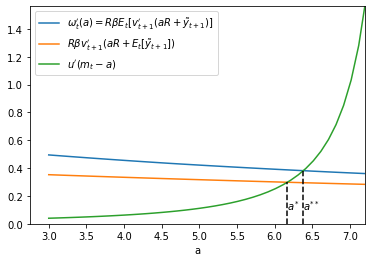

In [4]:
# Figure 1

def uP(agent, c):
    '''
    Computes the marginal utility of consumption for an agent with
    CRRA utility at a consumption level c.
    '''
    return( c**(-agent.CRRA) )
    
def approxOmegaP(agent, a_min, a_max):
    '''
    Constructs a function that computes the discounted expected marginal value
    of wealth next period w'(a) for a grid of end of period assets using the
    fact that optimal consumption c() satisfies u'(c(m_t)) = w'_t(m_t - c(m_t))
    '''

    # Find the level of resourses that would generate a_min and a_max as
    # as optimal responses
    aux = lambda m: m - agent.solution[0].cFunc(m)
    m_min = root_scalar(lambda m: a_min - aux(m), x0 = a_min, x1 = a_max).root
    m_max = root_scalar(lambda m: a_max - aux(m), x0 = a_min, x1 = a_max).root
    
    # Create grids
    m_grid = np.linspace(min(m_min, m_max)-1, max(m_min, m_max)+1, 1000)
    c_grid = agent.solution[0].cFunc(m_grid)
    a_grid = m_grid - c_grid
    
    # Omega prime is U' at the optimal C.
    omega_grid = uP(agent, c_grid)
    
    # Construct interpolating function
    omegaP = interp1d(a_grid, omega_grid, kind='cubic')
    
    return(omegaP)


m = 8
a_min = 3
a_grid = np.linspace(a_min, m*0.99, 50)

# Approximate omega with and without uncertainty
omegaP_uncert = approxOmegaP(IndShockConsumer, a_grid[0], a_grid[-1])
omegaP_PF = approxOmegaP(PFConsumer,  a_grid[0], a_grid[-1])

# Find intercepts with marginal utility
a_star1 = root_scalar(lambda a: omegaP_PF(a) - uP(PFConsumer, m - a),
                      bracket = [a_min, m-0.01]).root
a_star2 = root_scalar(lambda a: omegaP_uncert(a) - uP(IndShockConsumer, m - a),
                      bracket = [a_min, m-0.01]).root
                      
# Line labels
lab1 = '$\omega_t\'(a) = R \\beta E_t [v_{t+1}\'(aR + \\tilde{y}_{t+1})]$'
lab2 = '$R \\beta v_{t+1}\'(aR + E_t[\\tilde{y}_{t+1}])$'
lab3 = '$u\'(m_t-a)$'

# Main lines

# Omega uncertainty
plt.figure()
plt.plot(a_grid, omegaP_uncert(a_grid), label = lab1)
# Omega Perfect foresight
plt.plot(a_grid, omegaP_PF(a_grid), label = lab2)
# Marginal utility
plt.plot(a_grid, uP(IndShockConsumer, m - a_grid), label = lab3)

# Intersection lines
plt.plot([a_star1,a_star1],[0,uP(PFConsumer, m - a_star1)],'k--')
plt.text(a_star1,0.1, '$a^*$')
plt.plot([a_star2,a_star2],[0,uP(IndShockConsumer, m - a_star2)],'k--')
plt.text(a_star2,0.1, '$a^{**}$')

plt.ylim(bottom = 0)
plt.xlim(right = m*0.9)
plt.ylim(top = uP(PFConsumer, m - m*0.9))
plt.xlabel('a')
plt.legend()

## Figure 2

Figure 2 compares optimal consumption with and without income uncertainty.
The three most important facts to note are:
1. Consumption under uncertainty is always lower than its perfect-foresight counterpart.
2. The difference between them vanishes as market resources approach infinity.
3. Under uncertain future income, the consumption function is concave.

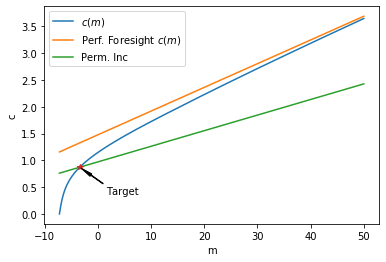

In [5]:
# Figure 2

# Define a function for the delta(m)=0 locus
m0_locus = lambda m: m - (m-1)/(IdiosyncDict["Rfree"]/
                         IdiosyncDict["PermGroFac"][0])

# Define grid of market resources
m_max = 50
m_grid = np.linspace(IndShockConsumer.solution[0].mNrmMin, m_max, 500)

# Main lines

# Uncertainty solution
plt.figure()
plt.plot(m_grid, IndShockConsumer.solution[0].cFunc(m_grid),
         label = '$c(m)$')
# Perfect foresight solution
plt.plot(m_grid, PFConsumer.solution[0].cFunc(m_grid),
         label = 'Perf. Foresight $c(m)$')
# Stable resource line
plt.plot(m_grid, m0_locus(m_grid), label = 'Perm. Inc')
# Target
targ = (IndShockConsumer.solution[0].mNrmSS,
        IndShockConsumer.solution[0].cFunc(IndShockConsumer.solution[0].mNrmSS))
plt.plot(targ[0], targ[1], '*')

# Annotations
plt.xlabel('m')
plt.ylabel('c')
plt.annotate('Target',
             xy = targ,
             xytext = (targ[0]+5, targ[1]-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05,
                             headwidth = 3, width = 0.5))
plt.legend()